In [190]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
import re
%matplotlib inline

# Predicting severe cases from deaths

In this script we will be predicting how many severe cases exist each day within a country from the cumulative number of deaths. 

We expect these numbers to be related, since deaths in theory all come from severe cases. We assume a constant death rate from severe cases over time. This entails that when deaths are on the rise, severe cases must be increasing as well. The time when severe cases are at their peak should be the time when deaths rise the most rapidly. When deaths start to flatten out, severe cases should be on the decline as well. 

This suggests a simple slope model for estimating severe cases. Since we are using cumulative deaths, the number will be monotonically increasing (or occassionally flat), meaning the slope over some number of days will never be negative. Similarly, the number of severe cases that exist per day cannot be negative. Following this train of thought, **we estimate the number of severe cases per day as the slope of cumulative deaths over some window of days, multiplied by a country-specific constant.** 

$$\#\ severe\ cases\ on\ day\ (i-lag\_days) = slope \Delta(deaths_{i-window\_size}...deaths_i)$$

Three are 3 parameters to this model:

1) window_size = how many days the sliding window should calculate the slope over

2) lag_days = the number of days earlier than the last date of the sliding window to assign predictions to (e.g. slope calculated over days 2-17 with 3 lag days is assigned to day 14 for prediction)

3) c = country-specific scaling constant for predictions

Note that severe cases here does not equal hospitalizations, since hospitalizations could include those who are not in the severe category and could fluctuate depending on bed capacity and admission policies by country/state/region. 

# General use

In [41]:
#Get data into the format: date | total deaths | total severe
#Names must be: date | deaths_ttl | severe_ttl

In [122]:
#Function to make predictions
#Returns a pandas df with date index | date | total deaths | total severe cases | predicted severe cases
def predict_severe(data, c, window_size = 15, lag_days = 3):
    data = data.reset_index(drop=True)
    data["dateind"] = data.index
    data = data[["dateind", "date", "deaths_ttl", "severe_ttl"]]
    
    #Filter for deaths, dropping missing obs
    deaths = data[["dateind", "deaths_ttl"]].dropna()

    #Add severe case prediction category (= slope * c)
    deaths["pred_severe"] = np.nan
    
    #Calculate slopes over a rolling window
    for i in range(window_size, deaths.shape[0]+1):
        X = deaths[i-window_size: i]["dateind"].to_numpy().reshape(-1, 1)
        Y = deaths[i-window_size: i]["deaths_ttl"].to_numpy().reshape(-1, 1)
        regressor = LinearRegression()  
        regressor.fit(X, Y)
        deaths.at[i-lag_days,"pred_severe"] = regressor.coef_[0] * c
    
    #Join back onto full data
    data = pd.merge(data, deaths,  
                    how='left', 
                    left_on=["dateind", "deaths_ttl"], 
                    right_on = ["dateind", "deaths_ttl"])
    
    return(data)

In [123]:
#Function to plot results
def plot_preds(data):
    #Blue = cumulative deaths
    #Orange = actual severe cases
    #Green = predicted severe cases
    plt.plot(data["date"], data["deaths_ttl"], data["severe_ttl"])
    plt.plot(data["date"], data["pred_severe"])
    plt.xticks(rotation=90)
    plt.show()

## France 

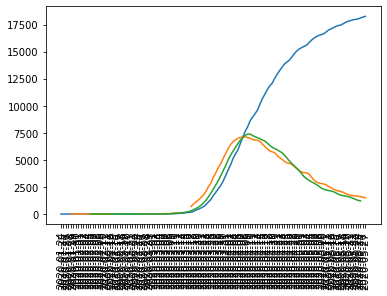

In [124]:
#Testing out
france = pd.read_csv("Data/france_cases_deaths_severe_recovered_ministresante.csv", header = 0)
france = predict_severe(france, 15)
plot_preds(france)

# China

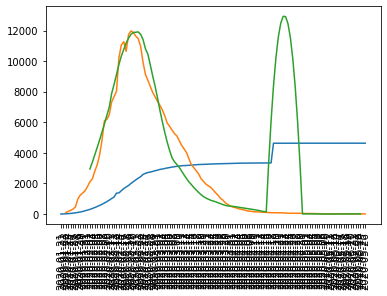

In [125]:
china = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
china = predict_severe(china, 100)
plot_preds(china)

# Italy

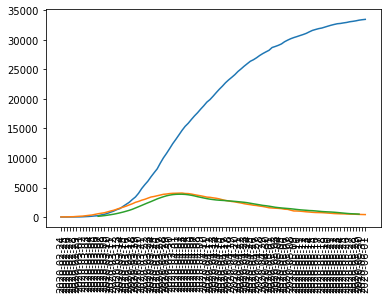

In [126]:
italy = pd.read_csv("Data/italy_daily_severe_hosp.csv", header = 0)
italy = italy[["data","terapia_intensiva","deceduti"]]
italy = italy.rename(columns={"data":"date", "terapia_intensiva":"severe_ttl", "deceduti":"deaths_ttl"})
italy[["date"]] = italy[["date"]].replace('T.*', '', regex=True)

italy = predict_severe(italy, 5)
plot_preds(italy)

# Spain

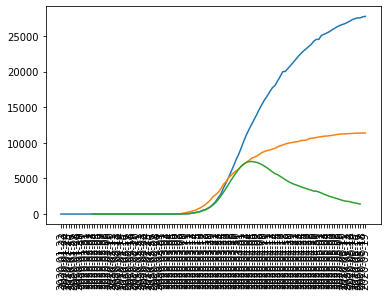

In [206]:
#Data is cumulative hospitalization, not severe cases
spain = pd.read_csv("Data/spain_icu_hospitalization.csv", header = 0)
world = pd.read_csv("Data/world_cases_deaths_recovered_JHU.csv", header = 0)
spain = pd.merge(world[world["country"] == "Spain"], spain,
                 how='left', 
                 left_on=["date"], 
                 right_on = ["fecha"])
spain = spain[["date","deaths","total_hosp"]]
spain = spain.rename(columns={"total_hosp":"severe_ttl", "deaths":"deaths_ttl"})

spain = predict_severe(spain, 9)
plot_preds(spain)

# Netherlands

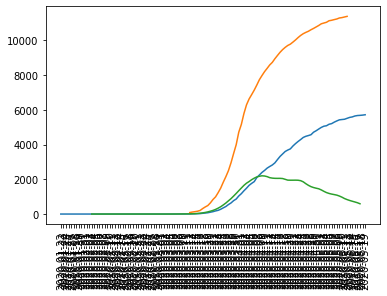

In [201]:
#This is also hospitalization data, not severe cases
neth = pd.read_csv("Data/netherlands_hospitalization_statista.csv", header = 0)
world = pd.read_csv("Data/world_cases_deaths_recovered_JHU.csv", header = 0)
neth = pd.merge(world[(world["country"] == "Netherlands") & pd.isnull(world["province"])], neth,
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])
neth = neth[["date", "deaths", "hospitalizations_ttl"]]
neth = neth.rename(columns = {"deaths":"deaths_ttl", "hospitalizations_ttl":"severe_ttl"})

neth = predict_severe(neth, 15)
plot_preds(neth)

# Canada

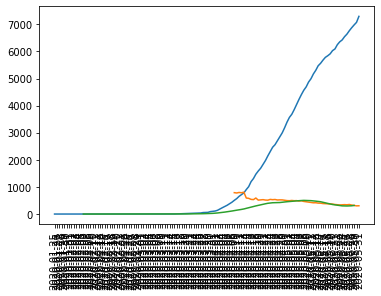

In [131]:
canada = pd.read_csv("Data/Canada_severe_case_data.csv", header = 0)
canada = canada[canada["Province"] == "CANADA"][["SummaryDate", "TotalDeaths", "TotalICU"]]
canada = canada.rename(columns = {"SummaryDate":"date", "TotalDeaths":"deaths_ttl", "TotalICU":"severe_ttl"})
canada[["date"]] = canada[["date"]].replace('/', '-', regex=True)
canada[["date"]] = canada[["date"]].replace(' .*', '', regex=True)

canada = predict_severe(canada, 3)
plot_preds(canada)

# US

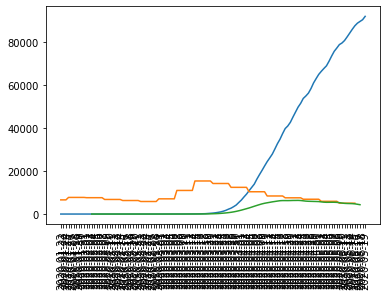

In [207]:
#Data is COVID-like illness emergency department visits, weekly
us = pd.read_csv("Data/US_ED_CLI_visits_clean.csv", header = 0)
us["CLI_ED_visits"] = us[["CLI_ED_visits"]].replace(',', '', regex=True)
us["CLI_ED_visits"] = pd.to_numeric(us["CLI_ED_visits"])
world = pd.read_csv("Data/world_cases_deaths_recovered_JHU.csv", header = 0)
us = pd.merge(world[world["country"] == "US"], us,
                 how='left', 
                 left_on=["date"], 
                 right_on = ["date"])
us = us[["date", "deaths", "CLI_ED_visits"]]
us = us.rename(columns = {"deaths":"deaths_ttl", "CLI_ED_visits":"severe_ttl"})
us["severe_ttl"] = us["severe_ttl"].bfill()/7 #Last observation carried backwards, daily avg

us = predict_severe(us, 3)
plot_preds(us)

# Brazil

# India